In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import seaborn as sns
import scipy
import math 
import random
from random import sample 
import gurobipy as gp

In [33]:
def find_csv_filenames(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [ ]:
directory = os.getcwd()
filenames = find_csv_filenames(directory)
hours_data = [l for l in filenames if l.startswith('alt_hour')]

#### Sample based

In [ ]:
s = 10  # number of runs
j = 3   # number of columns for results (opt, c_up, and c_down)
k = 24  # number of hours
optresults_SAA = np.zeros((s, j, k))

In [ ]:
# calculate sample size
eps = 0.1
delta = 0.01
p = 2

n = math.ceil((2/eps)*np.log(1/delta) + 2*p + (2*p/eps)*np.log(2/eps))

B_list = np.zeros((s, k))

for data in hours_data:
    for i in range(s):
        random.seed(i)
        list1 = range(0, 365) 
        samples = sample(list1, n)
        not_samples = list(set(list1) - set(samples))
        df = pd.read_csv(directory + "\\" + data)
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        Mu = np.max(df['upward'])
        Md = np.max(df['downward'])
        Me = np.max(df['energy'])

        # Create a new model
        m = gp.Model()

        # Create variables
        c1 = m.addVar(vtype='C', name="c1")
        c2 = m.addVar(vtype='C', name="c2")
        z = m.addVars(n, vtype='B', name="z")
        B = m.addVar(vtype='C', name="B")

        # Set objective function
        m.setObjective(c1 + c2, gp.GRB.MAXIMIZE)

        # Add constraints
        m.addConstrs(0.2*c2 + c1  - df['upward'][samples[j]] <= z[j]*Mu for j in range(0, n))
        m.addConstrs(c2 - df['downward'][samples[j]] <= z[j]*Md for j in range(0, n))
        m.addConstrs(c2 - df['energy'][samples[j]] <= z[j]*Me for j in range(0, n))
        m.addConstr(z.sum() == int(n*eps))
        m.addConstr(B == z.sum())

        # Solve it!
        m.optimize()

        # Get results
        optresults_SAA[i, 0, k - 1] = m.objVal
        optresults_SAA[i, 1, k - 1] = c1.X
        optresults_SAA[i, 2, k - 1] = c2.X
        B_list[i, k - 1] = B.X


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 650 rows, 219 columns and 1945 nonzeros
Model fingerprint: 0x42d88106
Variable types: 3 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 5e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 217 rows and 1 columns
Presolve time: 0.01s
Presolved: 433 rows, 218 columns, 1296 nonzeros
Variable types: 2 continuous, 216 integer (216 binary)

Root relaxation: objective 2.410871e+03, 199 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

#### Analytical reformulation

In [ ]:
s = 10  # number of runs
j = 7   # number of columns for distribution fitting (hour, kappa (Weibull), gamma (Weibull), nll, D (KS test), p (KS test), quantile value (90%))
k = 24  # number of hours
downfit = np.zeros((s, j, k))
upfit = np.zeros((s, j, k))
energyfit = np.zeros((s, j, k))

In [62]:
def distfitting(df, q, g, n):
    df = df - q
    m = len(df)
    nll = np.zeros((len(g)))
    j = 0
    for i in g:
        nll[j] = m*np.log(n) - m*np.log(np.sum(df**i)) + m*np.log(i) + (i - 1)*np.sum(np.log(df)) - m
        j = j + 1
    ind = np.argmax(nll)
    return m/np.sum(df**g[ind]), g[ind], -nll[ind]

In [63]:
def KStest(df, kappa, gamma):
    tmp1 = scipy.stats.ecdf(df)
    tmp1 = tmp1.cdf.probabilities
    tmp2 = 1-np.exp(-kappa*df**(gamma))
    kstest = scipy.stats.kstest(sorted(tmp1), sorted(tmp2))
    return kstest.statistic, kstest.pvalue

In [64]:
# Potential gamma values
g = np.linspace(0.01, 3, num=200)

# calculate sample size
eps = 0.1
delta = 0.01
p = 2
n = math.ceil((2/eps)*np.log(1/delta) + 2*p + (2*p/eps)*np.log(2/eps))

for i in range(s):
    random.seed(i)
    list1 = range(0,365) 
    samples = sample(list1, n)
    not_samples = list(set(list1) - set(samples))
    for data in hours_data:
        df = pd.read_csv(directory + "\\" + data)
        df = df.iloc[samples]
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        downfit[i, 0, k - 1], upfit[i, 0, k - 1], energyfit[i, 0, k - 1] = k, k, k

        # Reflect the data to estimate upper tail instead of lower
        df['downward old'] = df['downward']
        df['downward'] = -df['downward old']

        df['upward old'] = df['upward']
        df['upward'] = -df['upward old']

        df['energy old'] = df['energy']
        df['energy'] = -df['energy old']

        downfit[i, 6, k - 1] = np.quantile(df['downward'], 0.9)
        quantiledfdown = df['downward'][df['downward'] > downfit[i, 6, k - 1]]

        upfit[i, 6, k - 1] = np.quantile(df['upward'], 0.9)
        quantiledfup = df['upward'][df['upward'] > upfit[i, 6, k - 1]]

        energyfit[i, 6, k - 1] = np.quantile(df['energy'], 0.9)
        quantiledfenergy = df['energy'][df['energy'] > energyfit[i, 6, k - 1]]

        # Fit Weibull distribution
        downfit[i, 1, k - 1], downfit[i, 2, k - 1], downfit[i, 3, k - 1] = distfitting(quantiledfdown, downfit[i, 6, k - 1], g, n)
        upfit[i, 1, k - 1], upfit[i, 2, k - 1], upfit[i, 3, k - 1] = distfitting(quantiledfup, upfit[i, 6, k - 1], g, n)
        energyfit[i, 1, k - 1], energyfit[i, 2, k - 1], energyfit[i, 3, k - 1] = distfitting(quantiledfenergy, energyfit[i, 6, k - 1], g, n)

        # KS test
        downfit[i, 4, k - 1], downfit[i, 5, k - 1] = KStest(quantiledfdown, downfit[i, 1, k - 1], downfit[i, 2, k - 1])
        upfit[i, 4, k - 1], upfit[i, 5, k - 1] = KStest(quantiledfup, upfit[i, 1, k - 1], upfit[i, 2, k - 1])
        energyfit[i, 4, k - 1], energyfit[i, 5, k - 1] = KStest(quantiledfenergy, energyfit[i, 1, k - 1], energyfit[i, 2, k - 1])

In [65]:
def Weibull_constraint(kappa, gamma, eps):
    return (-(1/kappa)*np.log(eps))**(1/gamma)

In [ ]:
s = 10  # number of runs
j = 3   # number of columns for optimization results
k = 24  # number of hours

optresults_anaform = np.zeros((s, j, k))

In [67]:
eps = 1

for i in range(s):
    for data in hours_data:
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        
        # Create a new model
        m = gp.Model()

        # Create variables
        c1 = m.addVar(vtype='C', name="c1")
        c2 = m.addVar(vtype='C', name="c2")

        # Set objective function
        m.setObjective(c1 + c2, gp.GRB.MAXIMIZE)

        # Add constraints
        m.addConstr(0.2*c2 + c1 <= -Weibull_constraint(upfit[i, 1, k - 1], upfit[i, 2, k - 1], eps/3) - upfit[i, 6, k - 1])
        m.addConstr(c2 <= -Weibull_constraint(downfit[i, 1, k - 1], downfit[i, 2, k - 1], eps/3) - downfit[i, 6, k - 1])
        m.addConstr(c2 <= -Weibull_constraint(energyfit[i, 1, k - 1], energyfit[i, 2, k - 1], eps/3) - energyfit[i, 6, k - 1])

        # Solve it!
        m.optimize()

        optresults_anaform[i, 0, k - 1] = m.objVal
        optresults_anaform[i, 1, k - 1] = c1.X
        optresults_anaform[i, 2, k - 1] = c2.X
        

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xb9c84c6a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 2e+03]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3036683e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.303668299e+03
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cor

In [ ]:
s = 10
k = 24
j = 4

# Overbidding stats
overbid_SAA = np.zeros((s, j, k))
overbidding_p_SAA = np.zeros((s, j, k))
overbid_ana = np.zeros((s, j, k))
overbidding_p_ana = np.zeros((s, j, k))

In [ ]:
# calculate sample size
eps = 0.1
delta = 0.01
p = 2
n = math.ceil((2/eps)*np.log(1/delta) + 2*p + (2*p/eps)*np.log(2/eps))

for data in hours_data:
    for i in range(s):
        random.seed(i)
        list1 = range(0,365) 
        samples = sample(list1, n)
        not_samples = list(set(list1) - set(samples))
        df = pd.read_csv(directory + "\\" + data)
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        df_OOS = df.iloc[not_samples]
        for j in range(len(df_OOS)):
            cons1 = optresults_anaform[0, 1, k - 1] + 0.2*optresults_anaform[0, 2, k - 1] - df_OOS['upward'][not_samples[j]] > 0
            cons2 = optresults_anaform[0, 2, k - 1] - df_OOS['downward'][not_samples[j]] > 0
            cons3 = optresults_anaform[0, 2, k - 1] - df_OOS['energy'][not_samples[j]] > 0
            if cons1: overbid_ana[i, 0, k - 1] = overbid_ana[i, 0, k - 1] + 1
            if cons2: overbid_ana[i, 1, k - 1] = overbid_ana[i, 1, k - 1] + 1
            if cons3: overbid_ana[i, 2, k - 1] = overbid_ana[i, 2, k - 1] + 1
            if (cons1 or cons2 or cons3):
                overbid_ana[i, 3, k - 1] = overbid_ana[i, 3, k - 1] + 1
            
            cons1 = optresults_SAA[i, 1, k - 1] + 0.2*optresults_SAA[i, 2, k - 1] - df_OOS['upward'][not_samples[j]] > 0
            cons2 = optresults_SAA[i, 2, k - 1] - df_OOS['downward'][not_samples[j]] > 0
            cons3 = optresults_SAA[i, 2, k - 1] - df_OOS['energy'][not_samples[j]] > 0
            if cons1: overbid_SAA[i, 0, k - 1] = overbid_SAA[i, 0, k - 1] + 1
            if cons2: overbid_SAA[i, 1, k - 1] = overbid_SAA[i, 1, k - 1] + 1
            if cons3: overbid_SAA[i, 2, k - 1] = overbid_SAA[i, 2, k - 1] + 1
            if (cons1 or cons2 or cons3):
                overbid_SAA[i, 3, k - 1] = overbid_SAA[i, 3, k - 1] + 1

        overbidding_p_ana[i, 0, k - 1] = overbid_ana[i, 0, k - 1]/(365 - n) * 100
        overbidding_p_ana[i, 1, k - 1] = overbid_ana[i, 1, k - 1]/(365 - n) * 100
        overbidding_p_ana[i, 2, k - 1] = overbid_ana[i, 2, k - 1]/(365 - n) * 100
        overbidding_p_ana[i, 3, k - 1] = overbid_ana[i, 3, k - 1]/(365 - n) * 100

        overbidding_p_SAA[i, 0, k - 1] = overbid_SAA[i, 0, k - 1]/(365 - n) * 100
        overbidding_p_SAA[i, 1, k - 1] = overbid_SAA[i, 1, k - 1]/(365 - n) * 100
        overbidding_p_SAA[i, 2, k - 1] = overbid_SAA[i, 2, k - 1]/(365 - n) * 100
        overbidding_p_SAA[i, 3, k - 1] = overbid_SAA[i, 3, k - 1]/(365 - n) * 100

#### Plot results

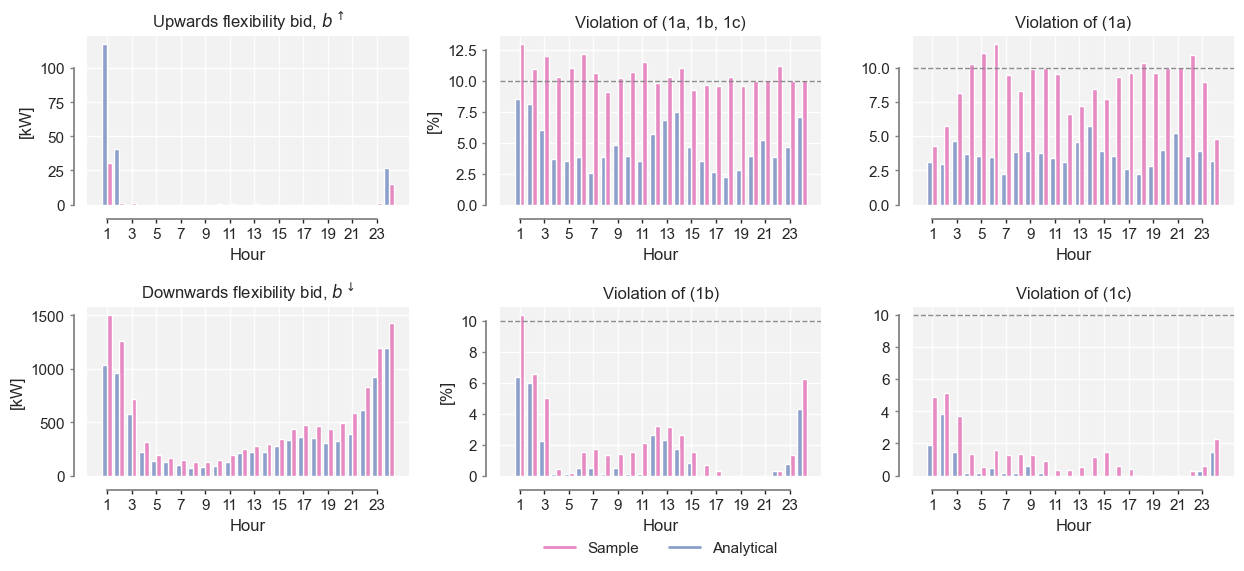

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='#e78ac3', lw=2, label='Sample'),
                Line2D([0], [0], color='#8da0cb', lw=2, label='Analytical')]

fig, axs = plt.subplots(2, 3, figsize=(0.7*18, 0.7*8))
sns.set_theme(context="paper", style="ticks")
sns.set_style({'axes.linewidth': 0.5})
sns.set(rc={'axes.facecolor':'#f2f2f2', 'figure.facecolor':'white'})

axs[0,0].set_ylabel('[kW]')
axs[0,0].set_title(r'Upwards flexibility bid, $b^\uparrow$')
axs[0,0].bar(range(0,24), optresults_SAA[:, 1, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,0].bar(range(0,24), optresults_anaform[:, 1, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')

axs[1,0].set_ylabel('[kW]')
axs[1,0].set_title(r'Downwards flexibility bid, $b^\downarrow$')
axs[1,0].bar(range(0,24), optresults_SAA[:, 2, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,0].bar(range(0,24), optresults_anaform[:, 2, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')

axs[0,1].set_title('Violation of (1a, 1b, 1c)')
axs[0,1].set_ylabel('[%]')
axs[0,1].bar(range(0,24), overbidding_p_SAA[:, 3, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,1].bar(range(0,24), overbidding_p_ana[:, 3, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[0,1].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[1,1].set_title('Violation of (1b)')
axs[1,1].set_ylabel('[%]')
axs[1,1].bar(range(0,24), overbidding_p_SAA[:, 1, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,1].bar(range(0,24), overbidding_p_ana[:, 1, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[1,1].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[0,2].set_title('Violation of (1a)')
axs[0,2].bar(range(0,24), overbidding_p_SAA[:, 0, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,2].bar(range(0,24), overbidding_p_ana[:, 0, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[0,2].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[1,2].set_title('Violation of (1c)')
axs[1,2].bar(range(0,24), overbidding_p_SAA[:, 2, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,2].bar(range(0,24), overbidding_p_ana[:, 2, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[1,2].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[0,0].tick_params(axis='y')
axs[0,0].grid(True)

for i in range(2):
    for j in range(3):
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_xticks(range(0, 24, 2), minor=False)
        axs[i,j].xaxis.grid(True, which='major', alpha=0.9)
        ticks = list(range(1, 25, 2))
        axs[i,j].set_xticklabels(ticks)

plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.left'] = True

for i in range(2):
    for j in range(3):
        for spine in axs[i,j].spines.values():
            spine.set_edgecolor('grey')
        axs[i,j].yaxis.set_tick_params(width=1, color='grey')
        sns.despine(ax=axs[i,j], offset=10, trim=True, right=True, bottom=False, left=False, top=True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

axs[1,1].legend(handles=custom_lines, fancybox=True, facecolor='white', framealpha=0, bbox_to_anchor=(0.5, -0.55), loc='lower center', ncol = 6) 
